In [15]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tables as tb
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm, trange

## fitting setting

In [16]:
from lmfit import Model, create_params
from lmfit.models import GaussianModel

mod = GaussianModel()


In [17]:
from scipy.special import erf


def damp_osci(x, x0, oa, rg, ro, phase, sigma, w):
    damp = oa * np.exp(-(x-x0)/rg)*np.cos((x-x0)/ro-phase)
    err_func = -0.5 * (erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w) ) + 0.5
    return damp * err_func

def exp_decay(x, Amplitude, x0, sigma, w, oa, rg, ro, phase):
    fit1 = Amplitude/2*np.exp(-(x-x0)/w + ((sigma/w)**2)/2)*(1-erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w))
    osc = damp_osci(x, x0, oa, rg, ro, phase, sigma, w)
    return fit1 + osc

def gaussian(x, Amplitude, x0, sigma):
    return Amplitude * np.exp(-np.power(x - x0, 2.) / (2 * np.power(sigma, 2.)))

gmodel = Model(exp_decay)

In [18]:
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['Amplitude', 'x0', 'sigma', 'w', 'oa', 'rg', 'ro', 'phase']
independent variables: ['x']


In [19]:
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)
params

name,value,initial value,min,max,vary
Amplitude,0.06000000,0.06,-inf,inf,True
x0,0.00000000,0.0,-inf,inf,True
sigma,0.10000000,0.1,-inf,inf,True
w,0.10000000,0.1,-inf,inf,True
oa,0.00000000,0,-inf,inf,False
rg,10.0000000,10,-inf,inf,False
ro,10.0000000,10,-inf,inf,False
phase,0.00000000,0,-inf,inf,False


In [20]:
dataset_for_intensity = {}
dataset_for_peak_shift = {}

In [21]:
time_drifts = {}

In [22]:
%matplotlib inline

In [23]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [24]:
plt.close('all')

## Jungfrau ROI1 signal

In [25]:
# run directory setting
run_n = 4
run_dir = f'/Users/olivershen/mnt/UED/Data/PAL_20250416_FXS/ue_250416_FXS/raw_data/h5/type=measurement/run={run_n:03}'
print(run_dir)
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

/Users/olivershen/mnt/UED/Data/PAL_20250416_FXS/ue_250416_FXS/raw_data/h5/type=measurement/run=004


In [28]:
# load data
for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = '',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        pulseid_label = 'event_info.pulse_id',
        #signal_label = 'pd:es:pd1:ch2',
        signal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum',
        #signal_label = 'detector:eh1:jungfrau2:frame.max',
        #roi1_area_label = 'detector:eh1:jungfrau2:ROI1_stat.area',
        #norm_label = 'pd:es:pd1:ch
        #norm_label = 'qbpm:oh:qbpm2:sum',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        #norm_label = 'detector:eh1:jungfrau2:ROI1_stat.sum',
        #norm2_label = 'detector:eh1:jungfrau2:ROI7_stat.sum',
      # newsignal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum'
    )
    positions = []
    signals = []
    ps = []
 
    for fname in tqdm(fnames[:], leave=True):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        elif 'phi_input' in df.columns.values:
            labels['position_label'] = 'phi_input'
        elif 'energy_input' in df.columns.values:
            labels['position_label'] = 'energy_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True

        norm = df_mini[labels['norm_label']] #- bkg_mean*df_mini[labels['roi3_area_label']]

        norm_mask = np.logical_and(
            norm > norm.mean() - norm.std()*2,
            norm < norm.mean() + norm.std()*2,
        )
        df_mini = df_mini[norm_mask]

        #bkg_mean = (df_mini[labels['bkg_label']] - df_mini[labels['signal_label']]) / (df_mini[labels['roi2_area_label']] - df_mini[labels['roi1_area_label']])
        roi_sum = (
            df_mini[[
                labels['signal_label'],
            ]].values
            ).sum(axis=1)
        norm = df_mini[labels['norm_label']]
        
        norm_grouped = dict()
        signal_grouped = dict()
        signal_ratio_grouped = dict()
        valid_grouped = dict()
        polynomial_param_grouped = dict()
        signal_norm_grouped = dict()
        ids_mod = (df_mini['event_info.pulse_id'].values%(72)/12).astype(int)
        for id_mod in np.unique(ids_mod):
            norm_grouped[id_mod] = norm[ids_mod == id_mod]
            signal_grouped[id_mod] = roi_sum[ids_mod == id_mod]
            signal_ratio_grouped[id_mod] = signal_grouped[id_mod] / norm_grouped[id_mod]
            valid_grouped[id_mod] = np.logical_and(
                signal_ratio_grouped[id_mod]<signal_ratio_grouped[id_mod].median() + signal_ratio_grouped[id_mod].std()*.3, 
                signal_ratio_grouped[id_mod]>signal_ratio_grouped[id_mod].median() - signal_ratio_grouped[id_mod].std()*.3
                )
            polynomial_param_grouped[id_mod] = np.polyfit(norm_grouped[id_mod], signal_grouped[id_mod], 1)
            signal_norm_grouped[id_mod] = np.average(
                signal_grouped[id_mod][valid_grouped[id_mod]] / norm_grouped[id_mod][valid_grouped[id_mod]],
                weights = norm_grouped[id_mod][valid_grouped[id_mod]]
                )

        positions.append(position)
        signals.append(signal_norm_grouped)
        ps.append(polynomial_param_grouped)            


        
    positions = np.array(positions)
    '''
    signals_on = np.array(signals_on)
    signals_off = np.array(signals_off)
    signals_diff = (signals_on - signals_off)/signals_off
    
    ps_on = np.array(ps_on)
    ps_off = np.array(ps_off)
    
    dataset_for_intensity[(run_n, scan_n)] = \
        {
            "labels": labels,
            "positions": positions,
            "signals_on": signals_on,
            "signals_off": signals_off,
            "signals_diff": signals_diff,
            "ps_on": ps_on,
            "ps_off": ps_off, 
        }
    '''

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

ZeroDivisionError: Weights sum to zero, can't be normalized

In [ ]:
# linearity check
plt.figure()
for i in range(6):
    plt.plot(
        norm_grouped[i],
        signal_grouped[i],
        '.',
        label = f'id: {i}', color=colors[i]
    )
    plt.plot(
        [0, norm_grouped[i].max()], 
        signal_norm_grouped[i] * np.array([0, norm_grouped[i].max()])
    )

# plt.ylim([-1000,20000])
plt.legend()
plt.show()

#print(f"run number = {run_n}")
avgavg = [
    np.average([signal_norm_grouped[0], signal_norm_grouped[1], signal_norm_grouped[2]]),
    np.average([signal_norm_grouped[3], signal_norm_grouped[4], signal_norm_grouped[5]])]
#print(f"Average of slope : (0,1,2):{avgavg[0]:.3e} / (3,4,5):{avgavg[1]:.3e}")
print(f"Difference : {100*(avgavg[0]-avgavg[1])/np.max(avgavg):.3f} %")

In [ ]:
#%matplotlib inline
#%matplotlib notebook

plt.figure(10)
for i in range(6):
    plt.plot(
        positions,
        [s[i] for s in signals],
        '.',
        label = f'id: {i}', color=colors[i]
    )
    
plt.legend()
plt.show()


In [17]:
%matplotlib inline

## Center of Mass

In [29]:
run_n = 4

run_dir = f'/Users/olivershen/mnt/UED/Data/PAL_20250416_FXS/ue_250416_FXS/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        #roi1_area_label = 'detector:eh1:jungfrau2:ROI2_stat.area',
        norm_label = 'qbpm:eh1:qbpm1:sum',
    )

    positions = []
    signals_x_on = []
    signals_x_off = []
    signals_y_on = []
    signals_y_off = []
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']]
        COMy = df_mini[labels['signal_y_label']] #+ 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event]
        norm_off = norm[pump_event != True]

        signal_x_on = COMx[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(
            signal_x_on ,#/ norm_on,
            weights = norm_on
        )
        signal_x_norm_off = np.average(
            signal_x_off ,#/ norm_off,
            weights = norm_off
        )
        signal_y_norm_on = np.average(
            signal_y_on ,#/ norm_on,
            weights = norm_on
        )
        signal_y_norm_off = np.average(
            signal_y_off ,#/ norm_off,
            weights = norm_off
        )

        positions.append(position)
        signals_x_on.append(signal_x_norm_on)
        signals_x_off.append(signal_x_norm_off)
        signals_y_on.append(signal_y_norm_on)
        signals_y_off.append(signal_y_norm_off)

    positions = np.array(positions)
    signals_x_on = np.array(signals_x_on)
    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on)
    signals_y_off = np.array(signals_y_off)

    signals_x_diff = (signals_x_off - signals_x_on)
    signals_y_diff = (signals_y_off - signals_y_on)

    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,
        "positions": positions,
        "signals_x_on": signals_x_on,
        "signals_x_off": signals_x_off,
        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,
        "signals_y_off": signals_y_off,
        "signals_y_diff": signals_y_diff,
    }
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

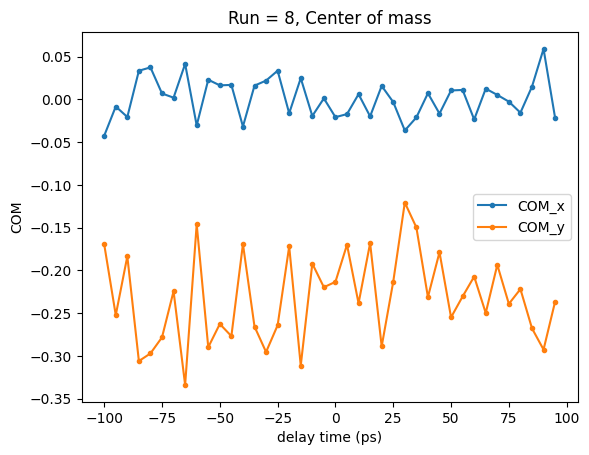

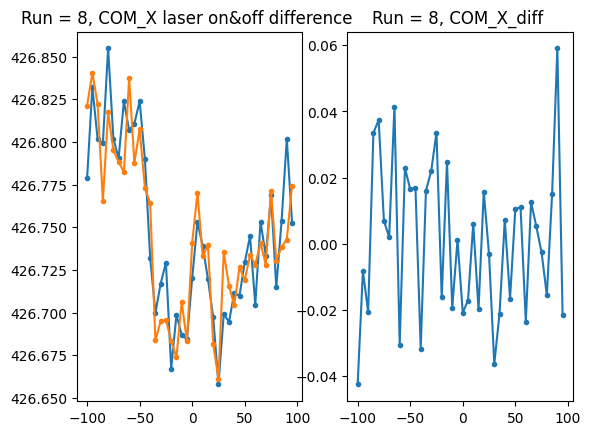

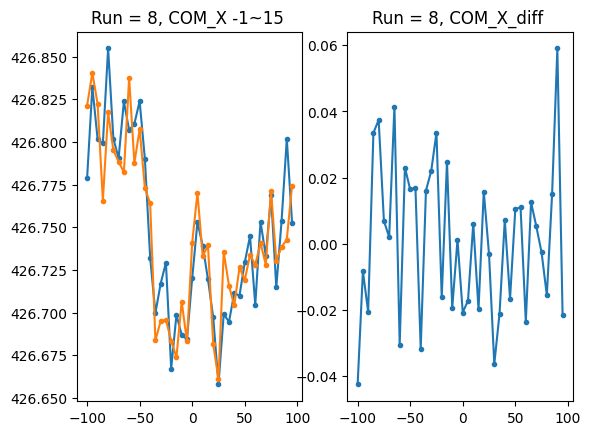

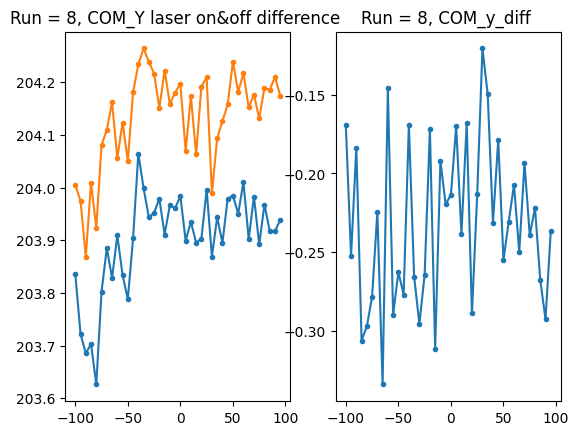

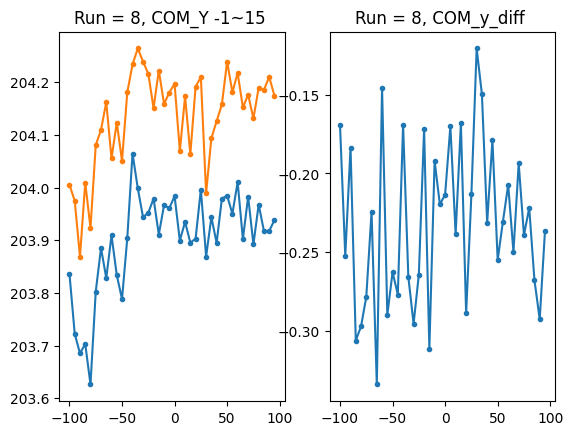

In [19]:
plt.figure(6)
for scan_n in scan_numbers:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
#plt.ylim(-1,2)
plt.xlabel('delay time (ps)')
plt.ylabel('COM')
plt.legend(['COM_x','COM_y'])
plt.title(f'Run = {run_n}, Center of mass')
#plt.ylim(-6, 0.5)
plt.show()

plt.figure(7)
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')

plt.figure(7)
plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.show()

plt.figure(8)
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X -1~15 ')
#plt.axis([-1, 15, 376, 379])

plt.figure(8)
plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
#plt.axis([-1, 15, -2, 0.2])
plt.show()


plt.figure(9)
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')

plt.figure(9)
plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_y_diff ')
plt.show()

plt.figure(10)
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y -1~15 ')
#plt.axis([-1, 15, 124, 126.5])

plt.figure(10)
plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_y_diff ')
#plt.axis([-1, 15, -1.5, 0.2])
plt.show()

In [20]:
run_n = 60

run_dir = f'/Users/olivershen/mnt/UED/palxfel raw/scripts/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        #signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        signal_x_label = 'pd:es:pd1:ch2',
        #signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        #roi1_area_label = 'detector:eh1:jungfrau2:ROI2_stat.area',
        #norm_label = 'qbpm:eh1:qbpm1:sum',
    )

    positions = []
    signals_x_on = []
    signals_x_off = []
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()]
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        signal = df_mini[labels['signal_x_label']]

        signal_on = signal[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_off = signal[pump_event != True]
        signals_x_on.append(signal_on.mean())
        signals_x_off.append(signal_off.mean())
        
        positions.append(position)
        
positions = np.array(positions)
signals_x_off = np.array(signals_x_off)
signals_x_on = np.array(signals_x_on)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

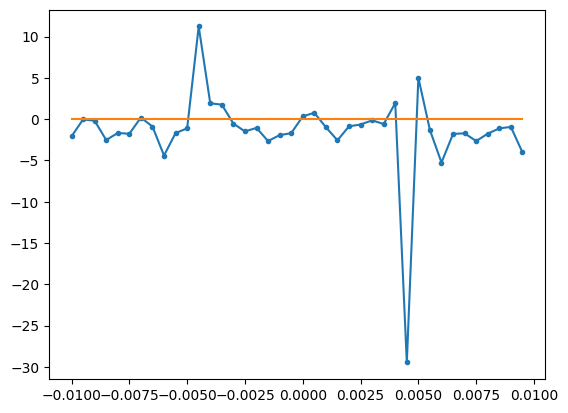

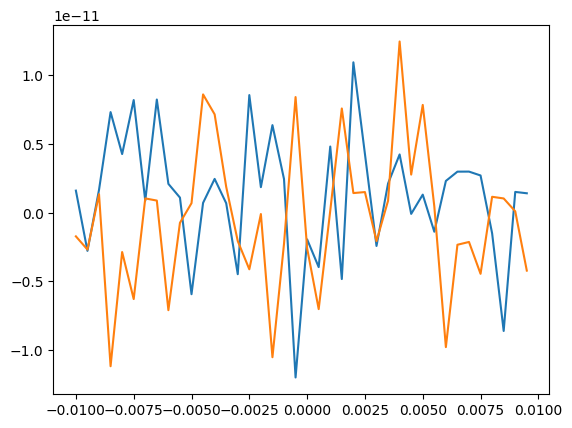

In [21]:
plt.figure()
plt.plot(positions, (signals_x_on - signals_x_off)/signals_x_off, '.-')
plt.plot([positions[0], positions[-1]], [0, 0])
plt.show()
plt.figure()
plt.plot(positions, signals_x_off)
plt.plot(positions, signals_x_on)
plt.show()